In [1]:
%load_ext tensorboard
import librosa
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path
import IPython.display as ipd

# prep

In [2]:
SAMPLE_RATE = 22050

In [3]:
def load():
    """
    Load 10 second chunks of songs
    """

    files = list(Path("./data/").glob("*.mp3"))
    chunks = []
    for file in files:
        y, sr =  librosa.load(file, mono=True,sr=SAMPLE_RATE)
        size = int(SAMPLE_RATE * 10)
        sampleLen = len(y)
        for startPos in range(0,sampleLen,size):
            end = startPos+size
            if end > sampleLen:
                pass
            chunk = y[startPos:end]
            chunks.append(chunk)
    return chunks

In [4]:
def dataset(chunks):
    x,y = [],[]
    size = int(SAMPLE_RATE*5)
    for chunk in chunks:
        Ax = chunk[:size]
        Ay = chunk[size:size*2]
        if(len(Ax) == size and len(Ay) == size):
            x.append(librosa.feature.melspectrogram(y=Ax, sr=SAMPLE_RATE))
            y.append(librosa.feature.melspectrogram(y=Ay, sr=SAMPLE_RATE))
    return x,y

In [5]:
def showSpec(spec):
    plt.figure(figsize=(10, 4))
    librosa.display.specshow(spec, sr=SAMPLE_RATE,
                             x_axis='time', y_axis='mel',
                             cmap='viridis')
    plt.colorbar(format='%+2.0f dB')
    plt.title('Mel spectrogram')
    plt.show()

In [6]:
def playSpec(spec):
    S = librosa.feature.inverse.mel_to_stft(spec, sr=SAMPLE_RATE)
    audio = librosa.griffinlim(S,n_iter=25,momentum=0.99)
    audio = librosa.effects.preemphasis(audio)  # Reapply pre-emphasis

    plt.figure(figsize=(12,4))
    plt.plot(audio)
    plt.title('waveform')
    plt.show()

    display(ipd.Audio(audio,rate=SAMPLE_RATE))

# Load Data

In [7]:
chunks = load()

In [8]:
x,y = dataset(chunks)

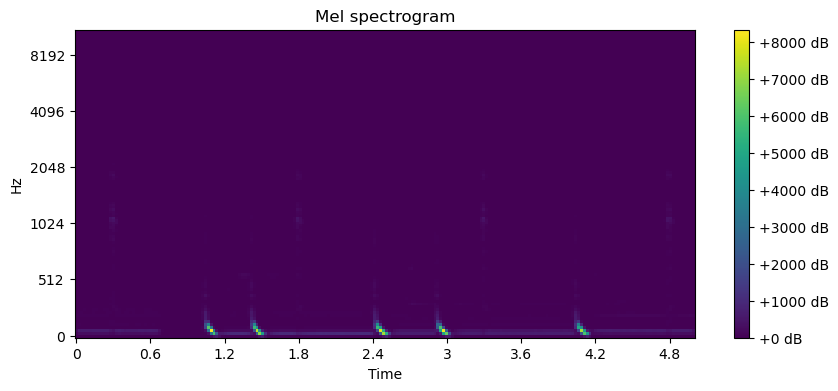

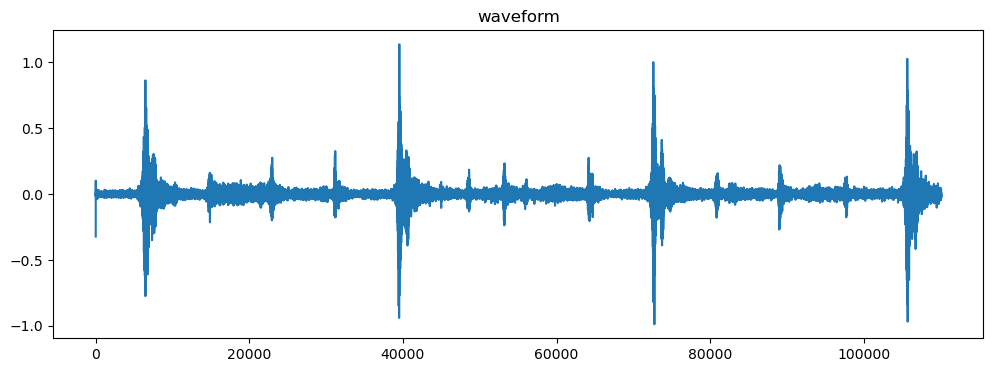

In [9]:
#verify loaded data
sample=x[420]
showSpec(sample)
playSpec(sample)

In [10]:
len(x[0][0])

216

In [11]:
from tinygrad import TinyJit, Device, Tensor, nn
from tinygrad.nn.state import safe_save, get_state_dict
from model import Model


In [12]:
x_np = np.array(x)[:, np.newaxis, :, :]  # Shape: (N, 1, 128, 216)
y_np = np.array(y)[:, np.newaxis, :, :]  # Shape: (N, 1, 128, 216)

# Training parameters
num_epochs = 15
batch_size = 20
num_samples = len(x_np)
num_batches = num_samples // batch_size

In [13]:
model = Model()
optimizer = nn.optim.Adam(nn.state.get_parameters(model), lr=1e-3)

In [24]:
@TinyJit
def jit_step(X: Tensor, Y: Tensor,show) -> Tensor:
    Tensor.training = True
    optimizer.zero_grad()
    sample, loss = model.__Lcall__(X,Y)
    loss.backward()
    optimizer.step()
    return loss.realize()


In [25]:
for epoch in range(num_epochs):
    epoch_loss = 0.0
    indices = np.random.permutation(num_samples)
    
    for batch_idx in range(num_batches):
        start = batch_idx * batch_size
        end = start + batch_size
        batch_x = Tensor(x_np[indices[start:end]])
        batch_y = Tensor(y_np[indices[start:end]])
        
        loss = jit_step(batch_x, batch_y,(batch_idx % 4 == 0))
        epoch_loss += loss.item()
    
    avg_epoch_loss = epoch_loss / num_batches
    print(f"Epoch {epoch+1}/{num_epochs}, Loss: {avg_epoch_loss:.4f}")

ParameterError: Audio buffer is not finite everywhere

In [ ]:
nn.state.safe_save(nn.state.get_state_dict(model), "vae_weights.safetensors")